In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions/text.csv


In [45]:
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AdamW
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
df = pd.read_csv('/kaggle/input/emotions/text.csv')

In [5]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [8]:
df.duplicated().sum()

686

In [9]:
df = df.drop_duplicates()

In [16]:
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [23]:
# Check the distribution of labels
label_counts = df['label'].value_counts()
label_counts

label
1    140779
0    120989
3     57235
4     47664
2     34497
5     14959
Name: count, dtype: int64

# Data Preprocessing

# Perform stratified sampling

In [24]:
# Perform stratified sampling to create a balanced dataset
balanced_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(label_counts)))

# Split the balanced dataset into train, validation, and test sets
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['label'], random_state=50)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=50)

# Check the distribution of labels in the balanced dataset
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())

label
4    11968
2    11967
0    11967
5    11967
1    11967
3    11967
Name: count, dtype: int64
label
5    1496
3    1496
1    1496
0    1496
2    1496
4    1495
Name: count, dtype: int64
label
1    1496
4    1496
5    1496
0    1496
2    1496
3    1496
Name: count, dtype: int64


/tmp/ipykernel_34/3072340471.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(label_counts)))


In [50]:
train_df.head()

,text,label,input_ids,attention_mask
129530,im dealing with a constant flow of feeling anx...,4,"[[tensor(101), tensor(10047), tensor(7149), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
193137,im not feeling too hot but mr,2,"[[tensor(101), tensor(10047), tensor(2025), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
269202,i woke up this morning feeling groggy edging a...,0,"[[tensor(101), tensor(1045), tensor(8271), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
406369,i think i am just going to end this post here ...,2,"[[tensor(101), tensor(1045), tensor(2228), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
284403,i feel a little bit amazed at how people do th...,5,"[[tensor(101), tensor(1045), tensor(2514), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [51]:
train_df.shape

(71803, 4)

In [52]:
val_df.head()

,text,label,input_ids,attention_mask
39292,i always want nemo by my side and sleeping wit...,5,"[[tensor(101), tensor(1045), tensor(2467), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
327229,i thought i would feel nervous you know about ...,4,"[[tensor(101), tensor(1045), tensor(2245), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
122255,im feeling pretty grumpy about living in this ...,3,"[[tensor(101), tensor(10047), tensor(3110), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
157849,i get intensely nauseous i feel worthless and ...,0,"[[tensor(101), tensor(1045), tensor(2131), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
228546,i dont want to drink a lot tonight because i h...,0,"[[tensor(101), tensor(1045), tensor(2123), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [53]:
val_df.shape

(8975, 4)

In [63]:
val_df['label'].value_counts()

label
5    1496
3    1496
1    1496
0    1496
2    1496
4    1495
Name: count, dtype: int64

In [17]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
# Tokenize the text data and encode labels
def preprocess_text(text):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64, 
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )

In [81]:
# Apply preprocessing to each row in the DataFrames
train_df['input_ids'] = train_df['text'].apply(lambda x: preprocess_text(x)['input_ids'])
train_df['attention_mask'] = train_df['text'].apply(lambda x: preprocess_text(x)['attention_mask'])

val_df['input_ids'] = val_df['text'].apply(lambda x: preprocess_text(x)['input_ids'])
val_df['attention_mask'] = val_df['text'].apply(lambda x: preprocess_text(x)['attention_mask'])

test_df['input_ids'] = test_df['text'].apply(lambda x: preprocess_text(x)['input_ids'])
test_df['attention_mask'] = test_df['text'].apply(lambda x: preprocess_text(x)['attention_mask'])

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['label'].values)
val_labels = torch.tensor(val_df['label'].values)
test_labels = torch.tensor(test_df['label'].values)

In [82]:
len(val_df['label'].values)

8975

In [83]:
len(val_labels)

8975

In [84]:
len(train_df['label'].values)

71803

In [85]:
len(train_labels)

71803

In [86]:
len(test_df['label'].values)

8976

In [87]:
len(test_labels)

8976

# Creating Pytorch datasets

In [88]:
# Define custom PyTorch Dataset class
class EmotionsDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

# Create instances of EmotionsDataset for training, validation, and test sets
train_dataset = EmotionsDataset(train_df['input_ids'].tolist(), train_df['attention_mask'].tolist(), train_labels)
val_dataset = EmotionsDataset(val_df['input_ids'].tolist(), val_df['attention_mask'].tolist(), val_labels)
test_dataset = EmotionsDataset(test_df['input_ids'].tolist(), test_df['attention_mask'].tolist(), test_labels)

# Define batch size and create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [89]:
for batch in train_loader:
    print(batch['input_ids'].shape)
    print(batch['attention_mask'].shape)
    print(batch['labels'].shape)
    break

torch.Size([32, 1, 64])
torch.Size([32, 1, 64])
torch.Size([32])


# Model Setup

In [90]:
# Define the number of emotion classes in your dataset
num_classes = len(train_df['label'].unique())

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Define loss function (cross-entropy for classification)
loss_fn = nn.CrossEntropyLoss()

# Move model and data loaders to appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Training Loop

In [91]:
print(len(val_labels), len(val_preds))

8975 8975


In [92]:
# Define number of epochs
num_epochs = 3  # You can adjust this based on your training requirements

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0  # Variable to accumulate total training loss
    
    for batch in train_loader:
        # Move batch to device
        inputs = batch['input_ids'].squeeze(1).to(device)
        attention_masks = batch['attention_mask'].squeeze(1).to(device)
        labels = batch['labels'].to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, attention_mask=attention_masks, labels=labels)

        # Compute loss
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate

        total_loss += loss.item()
        
    # Calculate average training loss for the epoch
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}: Avg. Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    num_val_batches = len(val_loader)
    val_preds = []  # Store predictions for evaluation metrics
    val_true_labels = []  # Store true labels for evaluation metrics

    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs = val_batch['input_ids'].squeeze(1).to(device)
            val_attention_masks = val_batch['attention_mask'].squeeze(1).to(device)
            val_true = val_batch['labels'].to(device)  # Rename val_labels to val_true

            val_outputs = model(val_inputs, attention_mask=val_attention_masks, labels=val_true)  # Use val_true for labels
            val_loss += val_outputs.loss.item()

            # Store predictions and true labels for evaluation metrics
            val_preds.extend(torch.argmax(val_outputs.logits, axis=1).cpu().numpy().tolist())
            val_true_labels.extend(val_true.cpu().numpy().tolist())  # Convert to numpy array for consistency

    avg_val_loss = val_loss / num_val_batches
    print(f"Epoch {epoch+1}/{num_epochs}: Avg. Validation Loss: {avg_val_loss:.4f}")

    # Calculate and print additional evaluation metrics
    val_accuracy = accuracy_score(val_true_labels, val_preds)  # Use val_true_labels instead of val_labels
    val_f1 = f1_score(val_true_labels, val_preds, average='weighted')  # Use val_true_labels instead of val_labels
    print(f"Epoch {epoch+1}/{num_epochs}: Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

    # Add additional evaluation metrics or logging as needed

Epoch 1/3: Avg. Training Loss: 1.8155
Epoch 1/3: Avg. Validation Loss: 1.8101
Epoch 1/3: Validation Accuracy: 0.1803, Validation F1 Score: 0.1262
Epoch 2/3: Avg. Training Loss: 1.8164
Epoch 2/3: Avg. Validation Loss: 1.8101
Epoch 2/3: Validation Accuracy: 0.1803, Validation F1 Score: 0.1262
Epoch 3/3: Avg. Training Loss: 1.8160
Epoch 3/3: Avg. Validation Loss: 1.8101
Epoch 3/3: Validation Accuracy: 0.1803, Validation F1 Score: 0.1262


In [93]:
model.eval()  # Set the model to evaluation mode
test_preds = []  # Store test predictions
test_labels = []  # Store ground truth labels

with torch.no_grad():
    for test_batch in test_loader:
        test_inputs = test_batch['input_ids'].squeeze(1).to(device)
        test_attention_masks = test_batch['attention_mask'].squeeze(1).to(device)
        test_true_labels = test_batch['labels'].to(device)

        # Perform forward pass for test data
        test_outputs = model(test_inputs, attention_mask=test_attention_masks)
        
        # Store predictions and true labels
        test_preds.extend(torch.argmax(test_outputs.logits, axis=1).cpu().numpy().tolist())
        test_labels.extend(test_true_labels.cpu().numpy().tolist())

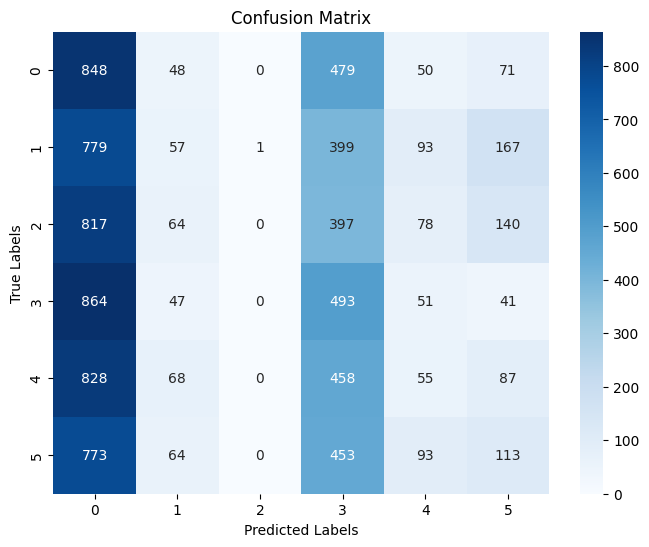

In [97]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix with blue color
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [99]:
conf_matrix

array([[848,  48,   0, 479,  50,  71],
       [779,  57,   1, 399,  93, 167],
       [817,  64,   0, 397,  78, 140],
       [864,  47,   0, 493,  51,  41],
       [828,  68,   0, 458,  55,  87],
       [773,  64,   0, 453,  93, 113]])

In [98]:
from sklearn.metrics import f1_score

# Calculate F1 score
test_f1 = f1_score(test_labels, test_preds, average='weighted')
print(f"Weighted F1 Score: {test_f1:.4f}")

Weighted F1 Score: 0.1212
